In [1]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.append(os.getcwd())
cwd_path = os.getcwd()

from kornia.nerf.camera_utils import parse_colmap_output, cameras_for_ids
from kornia.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

/workspaces/kornia


## Load scene images and plot one of them

In [2]:
# scene_dir = 'kornia/nerf/kornia_nerf_data/flower_4/'
scene_dir = 'kornia/nerf/kornia_nerf_data/head_sculpture/'

torch.Size([3, 2731, 1536])
1


torch.Size([2731, 1536, 3])

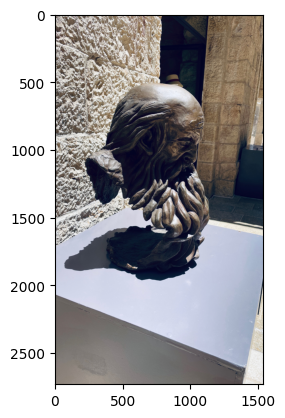

In [3]:
img_dir = os.path.join(scene_dir, 'images')
img_ext = 'jpeg'

img_paths = sorted(glob.glob(f'{img_dir}/*.{img_ext}'))

# img_paths = sorted(glob.glob('kornia/nerf/kornia_nerf_data/flower_4/images/*.png'))
# img_paths = sorted(glob.glob('kornia/nerf/kornia_nerf_data/head_sculpture/images/*.jpeg'))


img0 = read_image(img_paths[0])
print(img0.shape)

downscale = 1.  # Scaling facor to downsize images for faster computation
height = int(img0.shape[1] / downscale)
width = int(img0.shape[2] / downscale)
transform = torchvision.transforms.Resize((height, width))
imgs: torch.tensor = []
camera_ids = []
num_cams_to_load = 1
for i, img_path in enumerate(img_paths):
    if num_cams_to_load != -1 and i == num_cams_to_load:
        break
    img = read_image(img_path)
    img = transform(img)  # Uncomment to apply downsizing
    imgs.append(img)
    camera_ids.append(i)

print(len(imgs))
img_plt = torch.permute(imgs[0], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

colmap_camera_model_path = os.path.join(scene_dir, 'cameras.txt')
colmap_images_model_path = os.path.join(scene_dir, 'images.txt')

img_names, cameras = parse_colmap_output(
    cameras_path=colmap_camera_model_path, 
    images_path=colmap_images_model_path, 
    device=device,
    dtype=torch.float32)

# To use same subset of cameras as input images
cameras = cameras_for_ids(cameras, camera_ids)

# Downscaling cameras
cameras = cameras.scale(1. / downscale)

print(cameras.batch_size)
for i in range(cameras.batch_size):
  print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

cpu
1
Intrinsics: 
tensor([[2.1368e+03, 0.0000e+00, 7.6800e+02, 0.0000e+00],
        [0.0000e+00, 2.1368e+03, 1.3655e+03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]); 
Extrinsics: 
tensor([[ 0.9725, -0.1501,  0.1782, -3.4447],
        [ 0.1539,  0.9881, -0.0076, -1.8845],
        [-0.1749,  0.0348,  0.9840,  2.7608],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


## Run training on image scene

In [5]:
# nerf_obj = NerfSolver(device=device)
# num_img_rays = 256
# batch_size = 256
# nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=2., ndc=True, imgs=imgs, num_img_rays=num_img_rays, 
#                        batch_size=batch_size, num_ray_points=128)

In [6]:
nerf_obj = NerfSolver(device=device, dtype=torch.float32)
num_img_rays = 1024
batch_size = 4096

nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=3., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=256, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=1)

Epoch: 0: epoch_psnr = 10.425772666931152; time: 20:36:33


In [ ]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [7]:
from kornia.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [8]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

KeyboardInterrupt: 

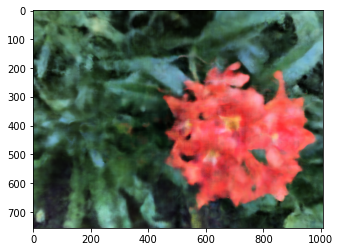

In [ ]:
plt.imshow(imgs_rendered[0])

### Spiral pattern

In [ ]:
from kornia.nerf.camera_utils import create_spiral_path

cameras_spiral = create_spiral_path(cameras, rad=1., num_views=30, num_circles=2)
imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

In [ ]:
import numpy as np
import imageio

imgs_rendered_spiral_numpy = [img_rendered_spiral.cpu().numpy() for img_rendered_spiral in imgs_rendered_spiral]

dir = 'kornia/nerf/kornia_nerf_data/flower_4'
scene_name = 'flower_4'
gif_path = os.path.join(dir, scene_name + '_spiral.gif')
imageio.mimwrite(gif_path, imgs_rendered_spiral_numpy, fps=30)

In [ ]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())

Output hidden; open in https://colab.research.google.com to view.